In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import plotly.express as px 

from tqdm import tqdm
import joblib
import os
import sys

# Appends the entire brainstation_capstone project folder to the path.
# This allows us to make a relative import of our scripts in brainstation_capstone/scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities import utils


DATA_PATH = utils.get_datapath('data')
FIG_PATH = utils.get_datapath('figures')

# **1. Exploratory Data Analysis**

This notebook will outline some early exploratory data analysis (EDA). Specifically we will look at:
- Release Date 
- Word Distributions
- Artists 

Additionally, this notebook will include EDA on the Spotify data that was scraped as the project evolved. This included:
- Spotify Popularity
- Genre Information

This project also included the document embeddings from the OpenAI second generation Ada text embedding model, which we will explore by using TSNE. 

In [3]:
# Load the dataset
df = pd.read_csv(DATA_PATH / 'clean_lyrics_final.csv')

# Distribution of Release Year

We will first see how the release years are divided in the dataset. 

In [4]:
fig = px.bar(
    df.release_year.value_counts().sort_index(ascending=True),
    width=600, height=600,
    template='xgridoff',
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)
    
fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Counts<b>',
        xaxis_title='<b>Release Year<b>',
        showlegend=False

)

fig.show()

with open(FIG_PATH / 'distribution_release_year.pkl', 'wb') as file:
    joblib.dump(fig, file)

We can see that a majority of the songs in this dataset are from the year 2009 to 2019, with the earliest song being from 1962 and the latest song being from 2020. 

# Word Distributions

Next we will look at the distributions of the words in the dataset. 

In [5]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [6]:
def corpus_getter(documents):
    # Get all the words in the dataset. 
    corpus = []
    for document in tqdm(documents):
        token_list = []
        for token in document.split(' '):
            if token not in ENGLISH_STOP_WORDS:
                token_list.append(token)

        corpus.extend(token_list)
    
    return corpus

In [7]:
# Get the entire corpus of the dataset.
corpus = corpus_getter(df.cleaned_lyrics)

100%|██████████| 28560/28560 [00:01<00:00, 26462.73it/s]


In [8]:
len(corpus)

7430378

In [9]:
# Make a Counter object to make counts of the unique tokens.
corpus_counter = Counter(corpus)
len(corpus_counter)

121600

In [10]:
summary_df = pd.DataFrame(
    {
        'Property': [
            'Total Number of Lyrics', 'Total Corpus Size', 'Total Unique Tokens', 
            'Earliest Release Date', 'Latest Release Date'
        ],
        'Value': [
            len(df), len(corpus), len(corpus_counter), 
            str(df['release_year'].min()), str(df['release_year'].max())
        ]
    }
)

In [11]:
summary_df

Property    Value
0  Total Number of Lyrics    28560
1       Total Corpus Size  7430378
2     Total Unique Tokens   121600
3   Earliest Release Date     1962
4     Latest Release Date     2020

In [12]:
with open(FIG_PATH / 'summary_df.pkl', 'wb') as file:
    joblib.dump(summary_df, file)

From the `Counter()` object above we can see that there are 130 854 unique tokens in the dataset. This is with common English stop words removed, as defined by `sklearn.feature_extraction.text.ENGLISH_STOP_WORDS`.  

In [13]:
corpus_df = pd.DataFrame(
    {
        'Word': list(corpus_counter.keys()),
        'Counts': list(corpus_counter.values())
    }
).iloc[1:, :]

In [14]:
# Sort the values by Counts.
corpus_df.sort_values(by='Counts', ascending=False, inplace=True)

sorted_top_50 = corpus_df[
    ~corpus_df['Word'].isin(['nigga', 'niggas', ''])
].iloc[:50, :]

# Most Common Words Overall

In [17]:
fig = px.bar(
    sorted_top_50[:20],
    x='Word',
    y='Counts',
    width=600, height=600,
    template='xgridoff',
    # title='<b>Most Common Words Used<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Counts<b>',
        xaxis_title='<b>Words<b>',
        showlegend=False

)

fig.show()



In [18]:
with open(FIG_PATH / 'distribution_words_overall.pkl', 'wb') as file:
    joblib.dump(fig, file)

# Most Common Verbs

In [19]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
parts_of_speech_for_each_word = nltk.pos_tag(list(corpus_counter.keys()))

In [21]:
verbs = []

for word in tqdm(parts_of_speech_for_each_word):
    if word[1] in ['VBP', 'VBN', 'VBG', 'VBD', 'VB', ' ', '']:
        verbs.append(word[0])



100%|██████████| 121600/121600 [00:00<00:00, 5307532.82it/s]


In [22]:
most_common_verbs = corpus_df[
    corpus_df['Word'].isin(verbs)
].sort_values(by='Counts', ascending=False)

In [23]:
fig = px.bar(
    most_common_verbs[:20],
    x='Word',
    y='Counts',
    width=600, height=600,
    template='xgridoff',
    # title='<b>Most Common Verbs Used<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Counts<b>',
        xaxis_title='<b>Verbs<b>',
        showlegend=False

)

fig.show()


In [25]:
with open(FIG_PATH / 'most_common_verb.pkl', 'wb') as file:
    joblib.dump(fig, file)

# Top 20 Words Used By Kendrick Lamar

We also want to just see how Kendrick Lamars word distribution is like. We will first separate out the most common 20 words in the dataset. This will allows us to see his most common words that are not similar to the most common words in the whole dataset.

In [26]:
# Separate out the most common words.
common_words = list(corpus_df['Word'][:20])

In [27]:
kendrick_df = df[
    df['primary_artist'].str.contains('Kendrick-lamar') |
    df['primary_artist'].str.contains('kendrick-lamar') 
]

In [28]:
len(kendrick_df)

217

In [29]:
kendrick_corpus = corpus_getter(kendrick_df['cleaned_lyrics'] )
kendrick_corpus_counter = Counter(kendrick_corpus)

100%|██████████| 217/217 [00:00<00:00, 18907.39it/s]


In [30]:
kendrick_corpus_df = pd.DataFrame(
    {
        'Word': list(kendrick_corpus_counter.keys()),
        'Counts': list(kendrick_corpus_counter.values())
    }
).iloc[1:, :]

In [31]:
# Sort the values by Counts.
kendrick_corpus_df.sort_values(by='Counts', ascending=False, inplace=True)

kendrick_corpus_df = kendrick_corpus_df[
    ~kendrick_corpus_df['Word'].isin(['nigga', 'niggas', ''] + common_words)
]

In [32]:
fig = px.bar(
    kendrick_corpus_df[:20],
    x='Word',
    y='Counts',
    width=600, height=600,
    template='xgridoff',
    # title='<b>Most Common Words Used By Kendrick Lamar<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Counts<b>',
        xaxis_title='<b>Words<b>',
        showlegend=False

)

fig.show()



In [33]:
with open(FIG_PATH / 'most_common_kendrick_lamar.pkl', 'wb') as file:
    joblib.dump(fig, file)

# Exploring Spotify Popularity

<AxesSubplot:ylabel='Frequency'>

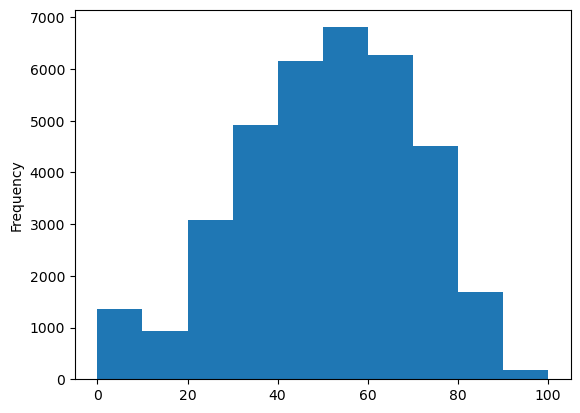

In [10]:
df['spotify_popularity'].plot(kind='hist')

In [9]:
df['spotify_popularity_three_class'].value_counts(normalize=True)

0    0.336787
2    0.334197
1    0.329016
Name: spotify_popularity_three_class, dtype: float64

# Exploring Genre

In [34]:
df['genre'].value_counts(normalize=True)

hip hop     0.412640
other       0.307143
pop         0.170728
rock        0.046394
trap        0.036345
r&b         0.021218
dance       0.005497
southern    0.000035
Name: genre, dtype: float64

We can see that most of the dataset is made up of hip hop songs, which is expected as most of our dataset is from a time period where hip hop has dominated the charts. 

## Exploring the Growth of Hip Hop

In [101]:
hip_hop_throughout_years = df[
    (df['genre'] == 'hip hop') &
    (df['release_year'] < 2020)
].groupby('release_year')['title'].count()

In [102]:
all_other_genres_throughout_years = df[
    ~(df['genre'] == 'hip hop') &
    (df['release_year'] < 2020)
].groupby('release_year')['title'].count()

In [103]:
percentage_of_hip_hop = hip_hop_throughout_years / (hip_hop_throughout_years + all_other_genres_throughout_years)

In [104]:
percentage_of_hip_hop = percentage_of_hip_hop.fillna(0)

In [105]:
fig = px.line(
    x=percentage_of_hip_hop.index,
    y=percentage_of_hip_hop.values,
    width=600, height=600,
    template='xgridoff'
 )

fig.update_traces(
    line_color='rgb(30, 215, 96)'
)


fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        xaxis_title='<b>Release Year<b>',
        yaxis_title='<b>Percent of Dataset<b>',
        showlegend=False,
        yaxis_range = [0, 0.8]

)


fig.show()

In [106]:
with open(FIG_PATH / 'growth_of_hip_hop.pkl', 'wb') as file:
    joblib.dump(fig, file)

# Dimensionality Reduction of Ada Embeddings Using TSNE

Here we will reduce the Ada embeddings into 3 dimensions using TSNE. 

In [1]:
from sklearn.manifold import TSNE

In [4]:
df = pd.read_csv(DATA_PATH / 'clean_lyrics_final.csv')

In [5]:
ada_embeddings = utils.get_ada_embeddings(df['ada_embeddings'])

In [8]:
tsne = TSNE(n_components=3, n_jobs=-1)

transformed_embeddings = tsne.fit_transform(ada_embeddings)

In [9]:
with open(DATA_PATH / 'ada_embeddings_tsne.pkl', 'wb') as file:
    joblib.dump(transformed_embeddings, file)

# Analyzing the Reduced Representation of Ada Embeddings

In [2]:
with open(DATA_PATH / 'ada_embeddings_tsne.pkl', 'rb') as file:
    transformed_embeddings = joblib.load(file)

In [3]:
transformed_embeddings.shape

(28560, 3)

In [7]:
df['tsne_component_1'] = transformed_embeddings[:,0]
df['tsne_component_2'] = transformed_embeddings[:,1]
df['tsne_component_3'] = transformed_embeddings[:,2]



In [29]:
def convert_to_text(popularity_class):
    if popularity_class == 0:
        return 'Low'
    elif popularity_class == 1:
        return 'Medium'
    elif popularity_class == 2:
        return 'High'

In [30]:
df['Spotify Popularity Class'] = df['spotify_popularity_three_class'].apply(convert_to_text)

In [38]:
tsne_df = df[
    (df['tsne_component_1'] < 70) 
    &
    (df['tsne_component_1'] > -80)
    &
    (df['tsne_component_1'] < 70)
    & 
    (df['tsne_component_1'] > -70)

]

In [63]:
color_map = {'Low':'white', 'Medium':'gray', 'High':'rgb(30, 215, 96)'}


fig = px.scatter(
        tsne_df,
        y='tsne_component_2',
        x='tsne_component_1',
        width=1000, height=1000,
        color='Spotify Popularity Class',
        template='xgridoff',
        hover_data=['title', 'primary_artist'],
        color_discrete_map=color_map,
        title='<b>Dimensionality Reduction of Ada Embeddings With TSNE<b>',
        opacity=0.5,
        category_orders={'Spotify Popularity Class': ['High', 'Medium', 'Low'] }
        )


fig.update_traces(
    textposition='top center',
    marker = dict(
        size=3
    )
)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        font=dict(
                size=12,
        ),
 
        yaxis_title='Component 2',
        xaxis_title='Component 1',
    )

fig.show()

We can see that there is no definitive separation from the first two dimensions between any of the classes. This supports the poor performance found in our models. 

# Investigating the Correlation Between Genius Page Views and Spotify Popularity 

In [5]:
df[['views','spotify_popularity']].corr()

views  spotify_popularity
views               1.000000            0.238672
spotify_popularity  0.238672            1.000000

We can see that the Genius page views have a low correlation with Spotify Popularity. We hope that by switching our target to Spotify Popularity we can have a better proxy for a songs popularity.